In [1]:
%matplotlib inline

In [2]:
import adolc

In [3]:
from adapt_utils.case_studies.tohoku.options import TohokuOkadaOptions

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Inverting the Okada model

In this notebook, $\mathbf m$ contains parameters associated with an Okada function representation on an array of subfaults.
That is, the initial surface elevation $\eta_0$ is given by

$$
    \eta_0(\mathbf x)=\mathrm{Okada}(\mathbf m),
$$

where $\mathrm{Okada}$ denotes the Okada model.

We can use `pyadolc` to differentiate through the Okada model, giving

$$
    \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}\:\widetilde{\mathrm m},
$$

for some choice of control parameters, $\widetilde{\mathrm m}$.
With an appropriate choice of seed vectors (i.e. a seed matrix), we can obtain the gradient

$$
    \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}.
$$

(See previous notebook for details.)
Henceforth let's drop the subscript zero and instead use $\eta_{ij}$ to indicate the $(i,j)^{th}$ entry on the Okada grid.

Suppose we have a source field $\eta^\star$.
We would like to establish Okada parameters $\mathbf m$ so that $\mathrm{Okada}(\mathbf m)\approx\eta^\star$.
One approach is to solve an optimisation problem of the form

$$
    \min J(\eta;\mathbf m)\quad\text{such that}\quad\eta=\mathrm{Okada}(\mathbf m),
$$

where $J$ quantifies how well $\eta$ matches $\eta^\star$ in some sense.
We opt for the mean square error as our error measure:

$$
    J(\eta;\mathbf m)=\frac1{N^2}\sum_{i=0}^{N-1}\sum_{j=0}^{N-1}(\eta_{ij}-\eta_{ij}^\star)^2.
$$

where the Okada grid has dimensions $N\times N$.

There are potentially redundancies in the Okada source model in the sense that very similar fields can be generated using different combinations of the input parameters.
If so then there could be uniqueness/local minima issues when applying gradient-based optimisation routines.
This notebook explores whether or not we need to worry.

### Initialisation

Set parameters and create a `TohokuOkadaOptions` object to hold them

In [5]:
kwargs = {
    'level': 0,
    'synthetic': True,
    'family': 'dg-cg',
    'okada_grid_resolution': 51,
    'debug': False,
}
plotting_kwargs = {
    'cmap': 'coolwarm',
    'levels': 50,
}
nonlinear = False

In [6]:
op = TohokuOkadaOptions(**kwargs)
op.create_topography()

In [7]:
N = op.N
X = op.fault.dtopo.X
Y = op.fault.dtopo.Y
eta = op.fault.dtopo.dZ.copy()

### Differentatiate the source model

Perturb the control parameters with some Normal random noise so that the source is different from that used to generate the gauge timeseries data.

In [8]:
kwargs['control_parameters'] = op.control_parameters
mu = 0
sigma = 5
for control in op.active_controls:
    size = np.shape(op.control_parameters[control])
    kwargs['control_parameters'][control] += np.random.normal(loc=mu, scale=sigma, size=size)

When setting the free surface initial condition using the Okada model, we tell `pyadolc` to annotate its tape.

In [9]:
tape_tag = 0
op = TohokuOkadaOptions(**kwargs)
# op.create_topography(annotate=True, tag=tape_tag)

In [10]:
# Initialise tape
adolc.trace_on(tape_tag)

# Read parameters and mark active variables as independent
msg = "Subfault {:d}: shear modulus {:4.1e} Pa, seismic moment is {:4.1e}"
for i, subfault in enumerate(op.subfaults):
    for control in op.all_controls:
        if control in op.active_controls:
            subfault.__setattr__(control, adolc.adouble(op.control_parameters[control][i]))
            adolc.independent(subfault.__getattribute__(control))
        else:
            subfault.__setattr__(control, op.control_parameters[control][i])
    op.print_debug(msg.format(i, subfault.mu, subfault.Mo().val))

# Create the topography, thereby calling Okada
op.print_debug("SETUP: Creating topography using Okada model...")
op.fault.create_dtopography(verbose=op.debug, active=True)
op.print_debug("SETUP: Done!")

# Compute quantity of interest
J_subfaults = [0.0 for j in range(op.N)]
for j in range(op.N):
    for i in range(op.N):
        J_subfaults[j] += (eta[i, j] - op.fault.dtopo.dZ_a[i, j])**2
    J_subfaults[j] /= op.N**2
        
# Mark output as dependent
adolc.dependent(J_subfaults)
adolc.trace_off()

Sum over all subfaults to get the total QoI

In [11]:
J = sum(J_sub.val for J_sub in J_subfaults)
print("QoI = {:.4e}".format(J))

QoI = 1.3120e-01


In [17]:
op.get_seed_matrices()
J, dJdm = adolc.fov_forward(tape_tag, op.input_vector, op.seed_matrices)
print(J.shape)
print(dJdm.shape)
print("QoI via AD = {:.4e}".format(sum(J)))

(51,)
(51, 4)
QoI via AD = 1.3120e-01


In [18]:
eta_pert = op.fault.dtopo.dZ.copy()

Check that the function stored to tape evaluates as it should

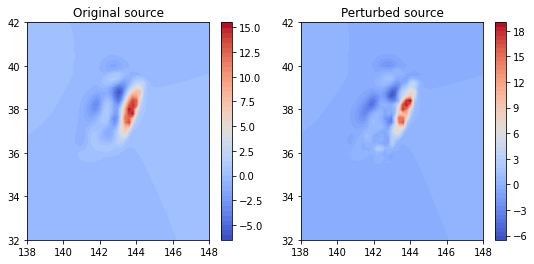

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4))
eta_pert = op.fault.dtopo.dZ.reshape(N, N)
fig.colorbar(axes[0].contourf(X, Y, eta, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Original source");
fig.colorbar(axes[1].contourf(X, Y, eta_pert, **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Perturbed source");

# TODO: inversion